In [15]:
from img_cap_lib import *
# imports
import torch
import torchvision
import torchtext
from torchtext.vocab import vocab, GloVe, Vectors
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import os
from PIL import Image
import string
from collections import OrderedDict, Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
import pickle
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import nltk

# Modellpfad festlegen

In [16]:
model_path = "models/tiny_model_with_normalisation.pt"

# Daten herunterladen

In [17]:
data_download("flickr8k_tiny")

flickr8k_tiny is not in the current directory
starting download...


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2285k  100 2285k    0     0   885k      0  0:00:02  0:00:02 --:--:-- 1108k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1063M  100 1063M    0     0  4511k      0  0:04:01  0:04:01 --:--:-- 4574k


Archive:  captions.zip
  inflating: captions/CrowdFlowerAnnotations.txt  
  inflating: captions/ExpertAnnotations.txt  
  inflating: captions/Flickr8k.lemma.token.txt  
   creating: captions/__MACOSX/
  inflating: captions/__MACOSX/._Flickr8k.lemma.token.txt  
  inflating: captions/Flickr8k.token.txt  
  inflating: captions/Flickr_8k.devImages.txt  
  inflating: captions/Flickr_8k.testImages.txt  
  inflating: captions/Flickr_8k.trainImages.txt  
  inflating: captions/readme.txt     
Archive:  images.zip
   creating: images/Flicker8k_Dataset/
  inflating: images/Flicker8k_Dataset/1000268201_693b08cb0e.jpg  
   creating: images/__MACOSX/
   creating: images/__MACOSX/Flicker8k_Dataset/
  inflating: images/__MACOSX/Flicker8k_Dataset/._1000268201_693b08cb0e.jpg  
  inflating: images/Flicker8k_Dataset/1001773457_577c3a7d70.jpg  
  inflating: images/__MACOSX/Flicker8k_Dataset/._1001773457_577c3a7d70.jpg  
  inflating: images/Flicker8k_Dataset/1002674143_1b742ab4b8.jpg  
  inflating: images/_

mv: rename images/Flickr8k_Dataset to flickr8k_tiny/images: No such file or directory


download complete


# Modell mit Normalisierung

## Modell laden

In [18]:
# load model
model_stats = torch.load(model_path, map_location=torch.device('cpu'))
model = load_captioning_model(model_stats)

## Preprocessing

In [19]:
# caption preprocessing
embedding_dim = 300
min_frequency = 1

captions = pd.read_csv("flickr8k_tiny/captions.txt")
caption_preprocessor = CaptionPreprocessor(embedding=model_stats['embedding'].embedding_matrix, vocabulary=model_stats['embedding'].vocabulary ,captions=captions, captions_path="flickr8k_tiny/captions.txt", embedding_dim=embedding_dim, min_frequency=min_frequency)
caption_preprocessor.preprocess()

# image preprocessing
img_preprocessor = ImagePreprocessor(normalize=True, image_folder_path="flickr8k_tiny", image_size=(112,112))
img_preprocessor.preprocess_images()

Shape captions: (40460, 2)


/Users/ronnyschneeberger/Documents/FHNW/HS22/del-image-captioning/img_cap_lib.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.captions.caption = self.captions.caption.apply(lambda x: x.strip("."))


Shape captions after filtering: (39749, 3)
Removed Captions:  711 , in Percent:  1.76
starting image preprocessing ...
image preprocessing finished


## Datensplit und DataLoader

In [20]:
# create split
training_data, test_data = train_test_split(caption_preprocessor.captions, test_size=0.15, random_state=42)

# create datasets
train_dataset = FlickrDataset(captions=training_data, embedding=model.embedding)
test_dataset = FlickrDataset(captions=test_data, embedding=model.embedding)

# create dataloaders
batch_size = 8
train_loader = FlickrLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = FlickrLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [21]:
def visualize_model_results(model, df:pd.DataFrame, n_samples=8):
    sample = df.sample(n_samples)

    for i, image_path in enumerate(sample.image.values):
        input = torchvision.io.read_image("flickr8k_tiny/transformed_images/" + image_path).float()
        image = Image.open("flickr8k_tiny/images/" + image_path)
        plt.imshow(image)
        plt.show()
        print("predicted")
        predicted_caption = model.forward(input.unsqueeze(0))
        predicted_caption = " ".join(predicted_caption)
        predicted_caption = predicted_caption.split('<EOS>')[0]
        predicted_caption = predicted_caption.lstrip('<SOS>')
        print(20*"-")
        print(predicted_caption + "\n")
        print("caption")
        print(20*"-")
        caption = sample["caption"].iloc[i]
        caption = " ".join(eval(caption))
        caption = caption.split('<EOS>')[0]
        caption = caption.lstrip('<SOS>')
        print(caption + "\n")

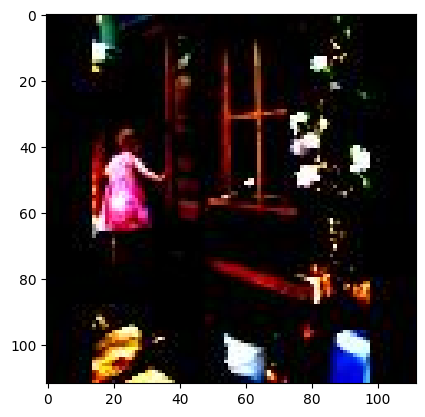

In [35]:
image = Image.open("flickr8k_tiny/transformed_images/1000268201_693b08cb0e.jpg")
plt.imshow(image)

In [34]:
image = torchvision.io.read_image("flickr8k_tiny/transformed_images/1000268201_693b08cb0e.jpg").float()
model.forward(image.unsqueeze(0))

array(['<SOS>', 'a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'learning',
       'how', 'to', 'climb', 'a', 'cliff', '<EOS>', '<PAD>', '<PAD>',
       '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'], dtype='<U8')

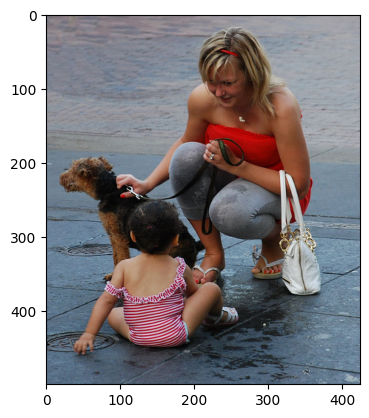

predicted
--------------------
 a man in a red shirt is learning how to climb a cliff 

caption
--------------------
 a woman showing a small dog to an infant 



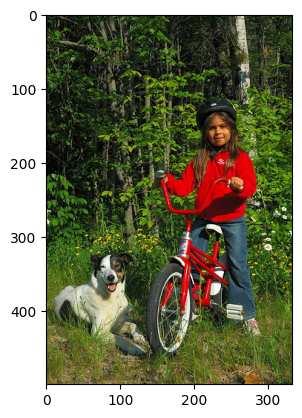

predicted
--------------------
 a man in a red shirt is learning how to climb a cliff 

caption
--------------------
 a child is sitting on a bike next to her dog 



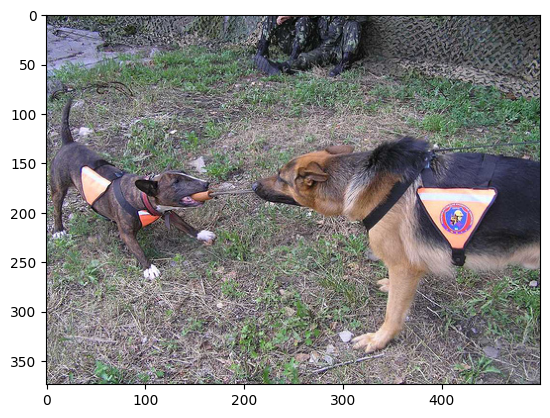

predicted
--------------------
 a man in a red shirt is learning how to climb a cliff 

caption
--------------------
 two dogs play tug of war 



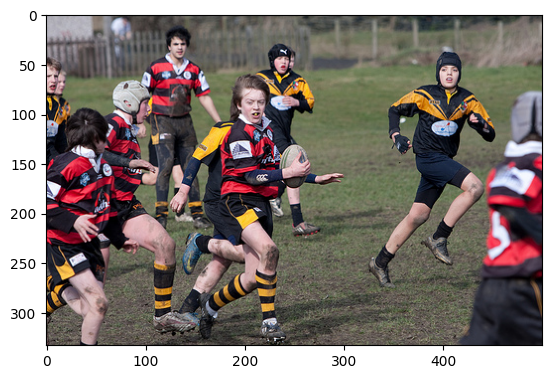

predicted
--------------------
 a man in a red shirt is learning how to climb a cliff 

caption
--------------------
 a female rugby player runs with a rugby ball during a match 



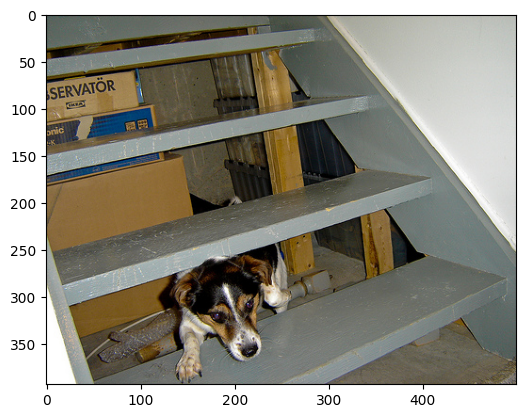

predicted
--------------------
 a man in a red shirt is learning how to climb a cliff 

caption
--------------------
 dog crawling in between steps from behind the steps 



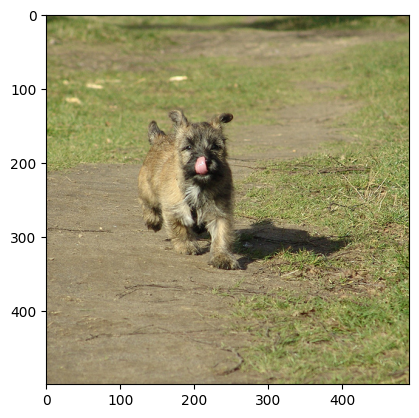

predicted
--------------------
 a man in a red shirt is learning how to climb a cliff 

caption
--------------------
 a dog playing ouside 



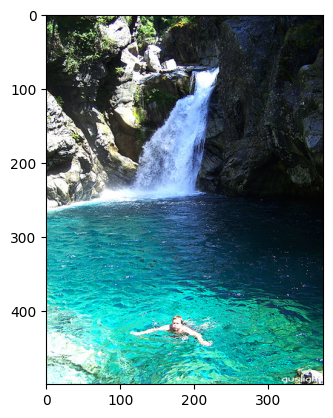

predicted
--------------------
 a man in a red shirt is learning how to climb a cliff 

caption
--------------------
 a person swimming in water nearby rocks and a small waterfall 



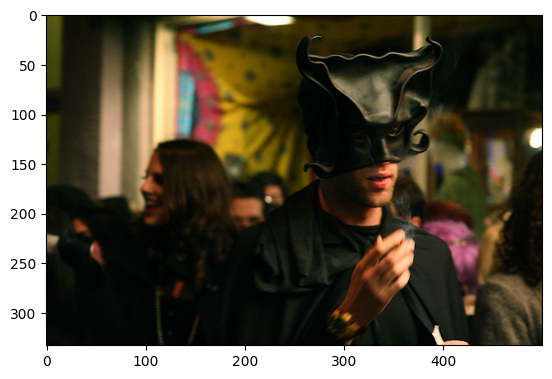

predicted
--------------------
 a man in a red shirt is learning how to climb a cliff 

caption
--------------------
 man dressed in black wearing elaborate black mask 



In [22]:
visualize_model_results(model, training_data)

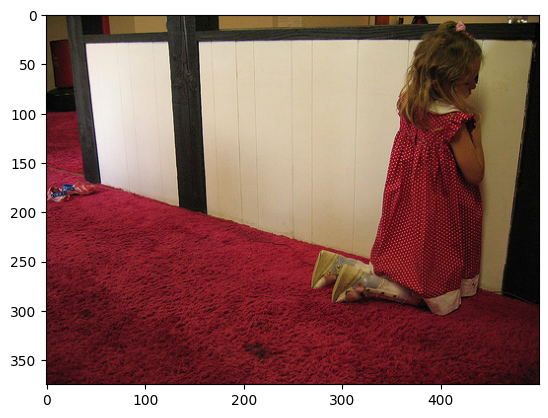

predicted
--------------------
 a man in a red shirt is learning how to climb a cliff 

caption
--------------------
 a young girl faces a white and black wall in a redcarpeted room 



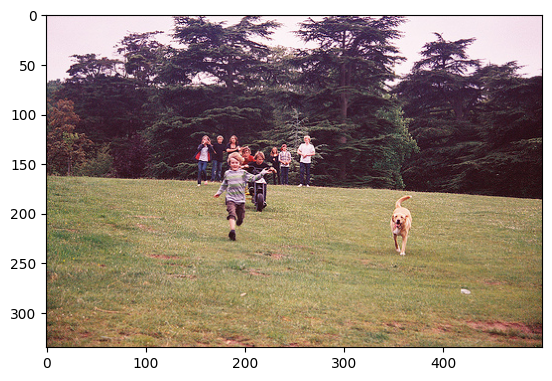

predicted
--------------------
 a man in a red shirt is learning how to climb a cliff 

caption
--------------------
 a group of children running with a dog down a grassy hill 



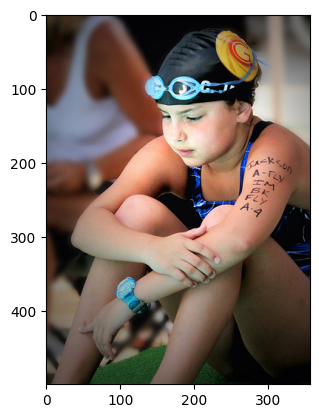

predicted
--------------------
 a man in a red shirt is learning how to climb a cliff 

caption
--------------------
 a young swimmer sits in a bathing suit and waits for the next race 



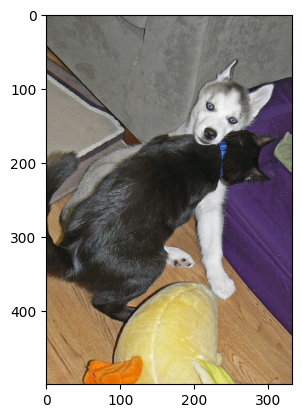

predicted
--------------------
 a man in a red shirt is learning how to climb a cliff 

caption
--------------------
 a black cat playing with a white puppy next to a duck toy 



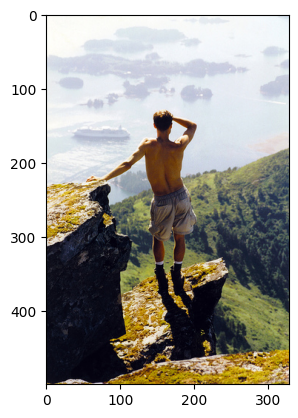

predicted
--------------------
 a man in a red shirt is learning how to climb a cliff 

caption
--------------------
 a man in shorts is standing on a rock looking out at the view from the hilltop 



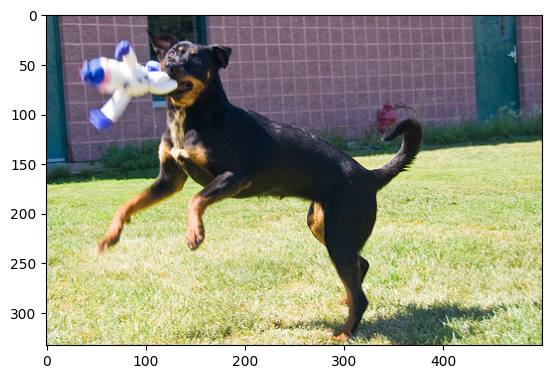

predicted
--------------------
 a man in a red shirt is learning how to climb a cliff 

caption
--------------------
 black dog playing with a white and blue toy 



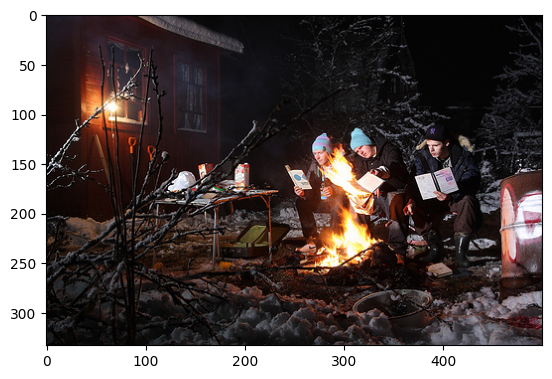

predicted
--------------------
 a man in a red shirt is learning how to climb a cliff 

caption
--------------------
 three people sit around a campfire 



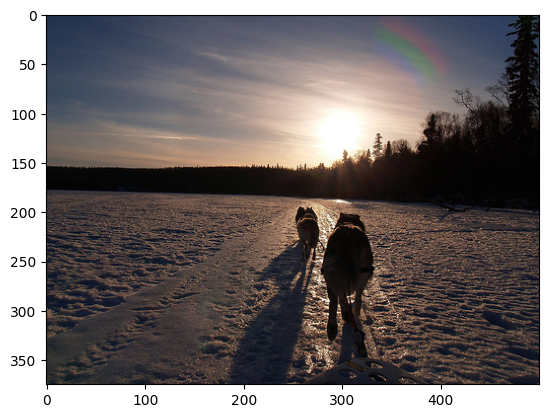

predicted
--------------------
 a man in a red shirt is learning how to climb a cliff 

caption
--------------------
 dogs are pulling a sled across the snow 



In [ ]:
visualize_model_results(model, test_data)